*testo in corsivo*# Transfer learning

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import get_file


In [ ]:
!unzip '/content/drive/MyDrive/Intelligent System Project/archive.zip' -d "/content"

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
import keras
import datetime

BASE_DIR = '/content/drive/MyDrive/Intelligent System Project/'
TRAIN_DIR = "archive/asl_alphabet_train/asl_alphabet_train/"
LABELS = list(filter(lambda x: x != ".DS_Store", sorted(os.listdir(TRAIN_DIR))))
LABEL_LIMIT = 3000

IMAGE_SIZE = (64, 64)
IMAGE_DEPTH = (3,)

In [5]:
# Helper function
import random
def load_images():

    images = []
    labels = []
    for idx, label in enumerate(LABELS):
        np.random.seed(idx)
        array = np.random.randint(1, 3000, size = LABEL_LIMIT)
        if os.path.isfile(TRAIN_DIR + label): continue
        for val in array:
            filepath = f"{TRAIN_DIR}{label}/{label}{val}.jpg"
            image = cv2.resize(cv2.imread(filepath), IMAGE_SIZE)
            images.append(image)
            labels.append(idx)
    images = np.array(images)
    labels = np.array(labels)
    return (images, labels)

images, labels = load_images()

## VGG16 Base model

In this notebook, we are building a model using the VGG16 architecture. We set the pre-trained VGG16 model as a base, froze its layers to keep the pre-trained weights, and added custom layers on top.

In [6]:
base_model = VGG16(input_shape = IMAGE_SIZE + IMAGE_DEPTH,
                   include_top = False,
                   weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False
base_model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [7]:
model = Sequential()

model.add(base_model)

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(len(LABELS), activation='softmax'))

model.summary()
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 29)                3741      
                                                                 
Total params: 14,980,701
Trainable params: 266,013
Non-trainable params: 14,714,688
_________________________________________________________________


We apply RGB normalization and data augmentation in order to have comparable results. After this, we train the custom layers on the output of the VGG16 model.

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=1)

# Image data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    brightness_range=(0.8, 1.2),
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=64)
validation_generator = val_datagen.flow(X_val, y_val, batch_size=64)
test_generator = test_datagen.flow(X_test, y_test, batch_size=64)

history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 64,
    validation_data=validation_generator,
    validation_steps=len(X_val) // 64,
    epochs=20
)

Epoch 1/20
1087/1087 [==============================] - 126s 107ms/step - loss: 0.9437 - accuracy: 0.7421 - val_loss: 0.3229 - val_accuracy: 0.9174
Epoch 2/20
1087/1087 [==============================] - 114s 105ms/step - loss: 0.3212 - accuracy: 0.9045 - val_loss: 0.1938 - val_accuracy: 0.9412
Epoch 3/20
1087/1087 [==============================] - 114s 105ms/step - loss: 0.2164 - accuracy: 0.9327 - val_loss: 0.1321 - val_accuracy: 0.9621
Epoch 4/20
1087/1087 [==============================] - 114s 105ms/step - loss: 0.1670 - accuracy: 0.9466 - val_loss: 0.1131 - val_accuracy: 0.9636
Epoch 5/20
1087/1087 [==============================] - 112s 103ms/step - loss: 0.1407 - accuracy: 0.9541 - val_loss: 0.0956 - val_accuracy: 0.9681
Epoch 6/20
1087/1087 [==============================] - 113s 104ms/step - loss: 0.1265 - accuracy: 0.9587 - val_loss: 0.1092 - val_accuracy: 0.9633
Epoch 7/20
1087/1087 [==============================] - 109s 100ms/step - loss: 0.1104 - accuracy: 0.9632 - val_

## Fine-tuning VGG16

We will now fine-tune the VGG16 by freezing all the layers except for the last three convolutional layers of the VGG16 base model.

In [ ]:
base_model.trainable = True

set_trainable = False
for layer in base_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dense_3 (Dense)             (None, 29)                3741      
                                                                 
Total params: 14,980,701
Trainable params: 7,345,437
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 64,
    validation_data=validation_generator,
    validation_steps=len(X_val) // 64,
    epochs=20
)

Epoch 1/20
1087/1087 [==============================] - 104s 93ms/step - loss: 0.0584 - accuracy: 0.9817 - val_loss: 0.0345 - val_accuracy: 0.9899
Epoch 2/20
1087/1087 [==============================] - 102s 94ms/step - loss: 0.0390 - accuracy: 0.9876 - val_loss: 0.0246 - val_accuracy: 0.9919
Epoch 3/20
1087/1087 [==============================] - 102s 94ms/step - loss: 0.0268 - accuracy: 0.9912 - val_loss: 0.0177 - val_accuracy: 0.9938
Epoch 4/20
1087/1087 [==============================] - 102s 94ms/step - loss: 0.0229 - accuracy: 0.9925 - val_loss: 0.0162 - val_accuracy: 0.9943
Epoch 5/20
1087/1087 [==============================] - 102s 94ms/step - loss: 0.0188 - accuracy: 0.9941 - val_loss: 0.0088 - val_accuracy: 0.9973
Epoch 6/20
1087/1087 [==============================] - 102s 94ms/step - loss: 0.0160 - accuracy: 0.9947 - val_loss: 0.0129 - val_accuracy: 0.9961
Epoch 7/20
1087/1087 [==============================] - 102s 94ms/step - loss: 0.0162 - accuracy: 0.9952 - val_loss: 0

## Final evaluation

We now plot both accuracy and loss to evaluate the final performances of our model.

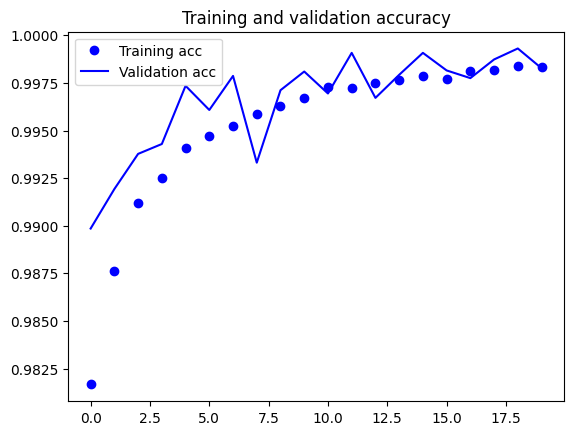

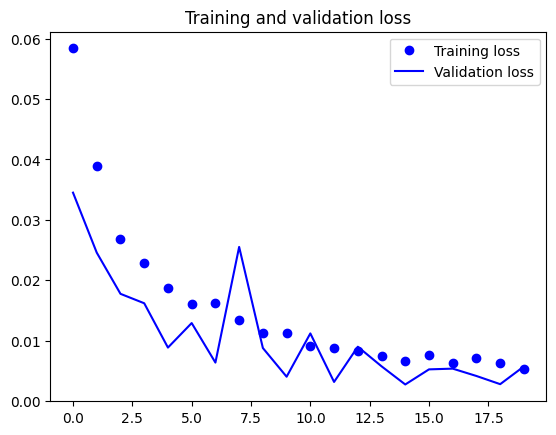

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.evaluate(test_generator, return_dict = True)

136/136 [==============================] - 4s 30ms/step - loss: 0.0048 - accuracy: 0.9982


{'loss': 0.004787056241184473, 'accuracy': 0.9981608986854553}

By leveraging a pre-trained model, we managed to achieve very good results while mantaining a simplified code structure and putting less effort compared to designing the network from scratch. However, it's important to highlight the fact that although this approach is more convenient, this network is considerably bigger and slower than the ad-hoc solution we provided in the previous notebook.
